# Fake News detection with tensorflow and nltk using LSTMs

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score,
    roc_curve, roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm


plt.style.use("ggplot")

# Base LSTM+ multimodal model

## Load data with features

In [2]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip && unzip -o -d data train-checkpoint3.zip

--2023-04-16 13:13:43--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip [following]
--2023-04-16 13:13:44--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85963394 (82M) [application/zip]
Saving to: 'train-checkpoint3.zip.1'

     0K .......... .......... .......... .......... ..........  0%  933K 90s
    50K .........

In [3]:
df = pd.read_csv("/kaggle/working/data/train-checkpoint3.csv", index_col=False)

In [4]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,text,text_norm,gulpease_index,smog_index,mean_word_len,real
0,isis leader ‘hiding in mosul’ as troops storm ...,"['isi', 'leader', 'hiding', 'mosul', 'troop', ...",51.2,12.9,5.808260,0.0
1,former speaker john boehner goes low…calls two...,"['former', 'speaker', 'john', 'boehner', 'go',...",62.3,9.9,5.899160,0.0
2,mh370 search: debris found in reunion may give...,"['mh370', 'search', 'debris', 'found', 'reunio...",51.0,13.1,6.231598,1.0
3,a leading us senator: us supporting war in sy...,"['leading', 'u', 'senator', 'u', 'supporting',...",48.0,15.2,6.139583,0.0
4,energy update – collective gridwork fluctuatio...,"['energy', 'update', 'collective', 'gridwork',...",55.8,12.3,6.546789,0.0


In [6]:
df = df.loc[:, df.columns != "text"] # Remove standalone text column

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "real"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [8]:
X_train

,text_norm,gulpease_index,smog_index,mean_word_len
32162,"['watch', 'news', 'camera', 'catch', 'drug', '...",45.1,0.0,5.555556
14001,"['state', 'department', 'say', 'find', 'email'...",49.6,12.9,6.414573
35625,"['trump', 'visit', 'asia', 'november', 'north'...",50.5,13.8,6.373434
37911,"['colombia', 'farc', 'leader', 'timochenko', '...",48.4,14.0,6.372624
36360,"['trump', 'torture', 'session', 'every', 'day'...",54.7,11.1,5.973684
...,...,...,...,...
6265,"['breaking', 'hispanic', 'men', 'coward', 'bea...",53.0,10.5,5.571429
11284,"['democratic', 'hopeful', 'sander', 'clinton',...",51.5,13.3,6.394256
38158,"['france', 'say', 'saudi', 'coalition', 'must'...",48.5,12.5,6.228070
860,"['palestinian', 'call', 'emergency', 'meeting'...",57.5,13.7,6.363636


In [9]:
X_train.describe()

,gulpease_index,smog_index,mean_word_len
count,34042.000000,34042.000000,34042.000000
mean,52.411480,11.969294,6.101352
std,5.576825,3.484700,0.396024
min,-47.900000,0.000000,3.649660
25%,49.000000,11.200000,5.877928
50%,52.000000,12.500000,6.121951
75%,55.400000,13.800000,6.352941
max,115.000000,28.600000,9.333333


In [10]:
X_train.dtypes

text_norm          object
gulpease_index    float64
smog_index        float64
mean_word_len     float64
dtype: object

In [11]:
y_train.describe()

count    34042.000000
mean         0.439134
std          0.496289
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: real, dtype: float64

Data looks good to create a model

## Final data processing (before model)

I expect a pandas DF that has the columns
- text_norm - Array of splitted and lemmatized words (English only)
- gulpease_index - ...
- smog_index - ...
- mean_word_len - Mean of lengths of words in the text_norm array

In [12]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [13]:
class ModelInputCreator(BaseEstimator, TransformerMixin):
    def __init__(self, max_vocab: int, max_len: int, texts_column: str, numerical_columns: List[str]):
        self.max_vocab = max_vocab
        self.max_len = max_len
        self.texts_column = texts_column
        self.numerical_columns = numerical_columns
        self.scaler = StandardScaler()
        self.tokenizer = Tokenizer(num_words=MAX_VOCAB)
        
    def fit(self, df: pd.DataFrame):
        df = df.reset_index(drop=True)
        self.tokenizer.fit_on_texts(df[self.texts_column])
        self.scaler.fit(df[self.numerical_columns])
        return self
    
    def transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        text_sequences = self.tokenizer.texts_to_sequences(df[self.texts_column])
        text_sequences = pad_sequences(text_sequences, padding="post", maxlen=MAX_LEN)
        numerical = self.scaler.transform(df[self.numerical_columns])
        return (text_sequences, numerical)
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        self.fit(df)
        return self.transform(df)

In [14]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)

In [15]:
X_train_transformed = input_creator.fit_transform(X_train)

In [16]:
X_train_transformed

(array([[ 270,   36, 1742, ...,    0,    0,    0],
        [ 815,   97,  989, ...,  285, 2645,   80],
        [ 163,    4,  312, ...,  602,   42,    2],
        ...,
        [ 890,   16,  418, ...,    0,    0,    0],
        [ 939,  142, 1354, ...,    0,    0,    0],
        [ 603, 1808,   16, ...,    0,    0,    0]]),
 array([[-1.31106621, -3.4348642 , -1.37820918],
        [-0.50414367,  0.26708755,  0.79092515],
        [-0.34275916,  0.52536325,  0.68704293],
        ...,
        [-0.7013914 ,  0.15229835,  0.31998076],
        [ 0.91245367,  0.49666595,  0.66230363],
        [-0.89863913,  0.61145515,  0.45234232]]))

# RNN Model

## Model building

In [17]:
text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)

num_input = tf.keras.Input(shape=(3,), name="num_input")
num_features = tf.keras.layers.Dense(32, activation='relu')(num_input)

merged = tf.keras.layers.concatenate([text_features, num_features])
merged = tf.keras.layers.Dense(8)(merged)
merged = tf.keras.layers.Dropout(0.5)(merged)
output = tf.keras.layers.Dense(1)(merged)

model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 256, 128)     2560000     ['text_input[0][0]']             
                                                                                                  
 bidirectional (Bidirectional)  (None, 256, 128)     98816       ['embedding[0][0]']              
                                                                                                  
 num_input (InputLayer)         [(None, 3)]          0           []                               
                                                                                              

## Model fitting

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1022/1022 [==============================] - 546s 520ms/step - loss: 0.3553 - accuracy: 0.8332 - val_loss: 0.1717 - val_accuracy: 0.9348
Epoch 2/10
1022/1022 [==============================] - 522s 511ms/step - loss: 0.1398 - accuracy: 0.9541 - val_loss: 0.1391 - val_accuracy: 0.9483
Epoch 3/10
1022/1022 [==============================] - 520s 509ms/step - loss: 0.0901 - accuracy: 0.9736 - val_loss: 0.1396 - val_accuracy: 0.9498
Epoch 4/10
1022/1022 [==============================] - 525s 514ms/step - loss: 0.0682 - accuracy: 0.9810 - val_loss: 0.1646 - val_accuracy: 0.9419


## Training Visualization

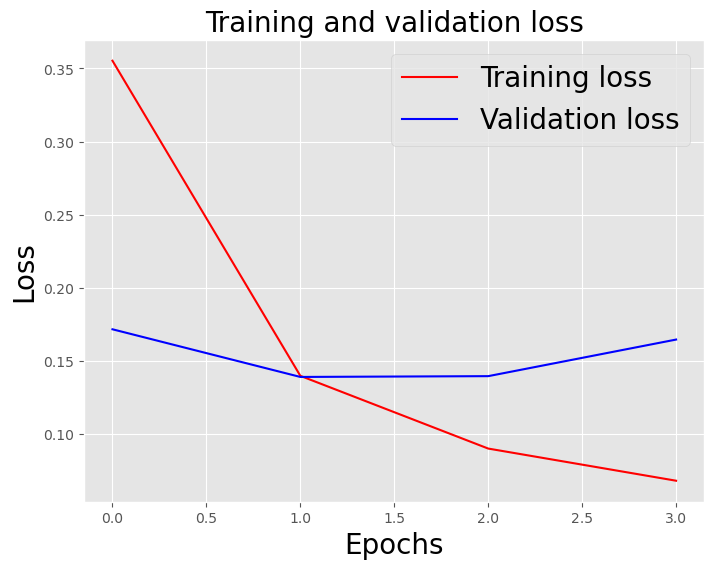

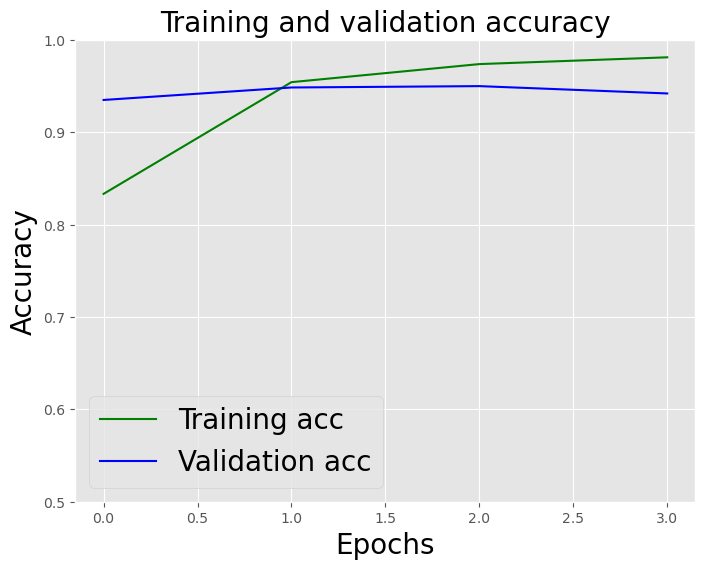

In [19]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

Evaluation of the testing set:

In [20]:
X_test_transformed = input_creator.transform(X_test)

In [21]:
model.evaluate(X_test_transformed, y_test)

266/266 [==============================] - 31s 115ms/step - loss: 0.1454 - accuracy: 0.9428


[0.14536139369010925, 0.9427799582481384]

In [22]:
y_pred = model.predict(X_test_transformed)
roc05 = (y_pred > 0.5) * 1

266/266 [==============================] - 33s 114ms/step


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

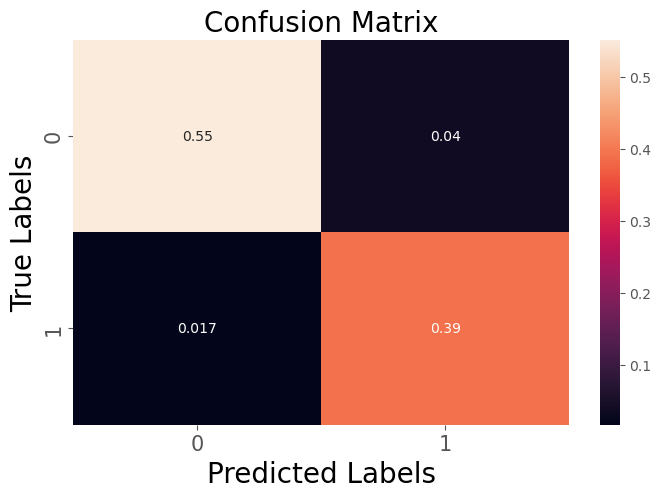

In [23]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [24]:
print(classification_report(y_test, roc05))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      4838
         1.0       0.96      0.91      0.93      3673

    accuracy                           0.94      8511
   macro avg       0.95      0.94      0.94      8511
weighted avg       0.94      0.94      0.94      8511



### ROC Curve

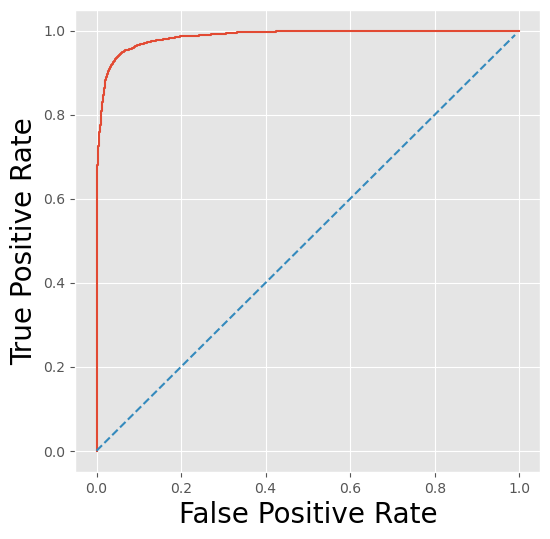

In [25]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

### AUC ROC i GINI

In [26]:
auc = roc_auc_score(y_test, y_pred)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.9866163563323165
GINI Score: 0.973232712664633


# Other models

With other models we will be using the concatenated matrix of tokenized words and text statistics

In [27]:
X_train_matrix = np.concatenate(X_train_transformed, axis=1)
X_test_matrix =  np.concatenate(X_test_transformed, axis=1)

## XGBoost model

In [28]:
# Train an XGBoost model on the training data, and get predictions for the test data
xgb_model = xgb.XGBClassifier(
    max_depth = 8,
    learning_rate = 0.03,
    objectives = "binary:logistic",
    verbosity=1
)
xgb_model.fit(X_train_matrix, y_train)

[13:50:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objectives" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objectives='binary:logistic', predictor=None, ...)

In [29]:
xgb_preds = xgb_model.predict(X_test_matrix)
xgb_preds

array([1, 0, 1, ..., 1, 0, 0])

In [30]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.86      4838
         1.0       0.86      0.75      0.80      3673

    accuracy                           0.84      8511
   macro avg       0.84      0.83      0.83      8511
weighted avg       0.84      0.84      0.84      8511



### ROC Curve

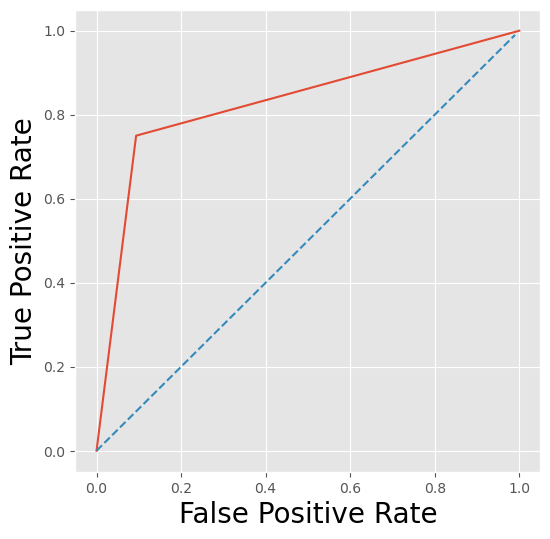

In [31]:
fpr, tpr, _ = roc_curve(y_test,  xgb_preds)

#create ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

### AUC ROC i GINI

In [32]:
auc = roc_auc_score(y_test, xgb_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.8282171656525776
GINI Score: 0.6564343313051553


## Logistic Regression

In [33]:
lr_model = LogisticRegression()

lr_model.fit(X_train_matrix, y_train)

LogisticRegression()

In [34]:
lr_preds = lr_model.predict(X_test_matrix)
lr_preds

array([1., 0., 0., ..., 1., 0., 1.])

In [35]:
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.78      0.71      4838
         1.0       0.61      0.45      0.52      3673

    accuracy                           0.64      8511
   macro avg       0.63      0.62      0.62      8511
weighted avg       0.64      0.64      0.63      8511



### ROC Curve

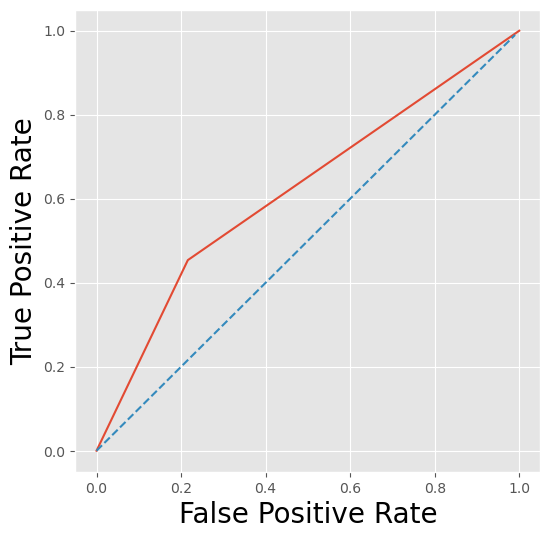

In [36]:
fpr, tpr, _ = roc_curve(y_test,  lr_preds)

#create ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

### AUC ROC i GINI

In [37]:
auc = roc_auc_score(y_test, lr_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.6189270451380514
GINI Score: 0.23785409027610283


## Random Forest

In [38]:
rf_model = RandomForestClassifier(n_estimators=800,
                                  max_depth=2,
                                  min_samples_split = 2,
                                  max_features = 3,
                                  random_state=0,
                                  n_jobs = -1)

rf_model.fit(X_train_matrix, y_train)

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=800, n_jobs=-1,
                       random_state=0)

In [39]:
rf_preds = rf_model.predict(X_test_matrix)
rf_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

         0.0       0.60      0.98      0.75      4838
         1.0       0.87      0.14      0.25      3673

    accuracy                           0.62      8511
   macro avg       0.73      0.56      0.50      8511
weighted avg       0.72      0.62      0.53      8511



### ROC Curve

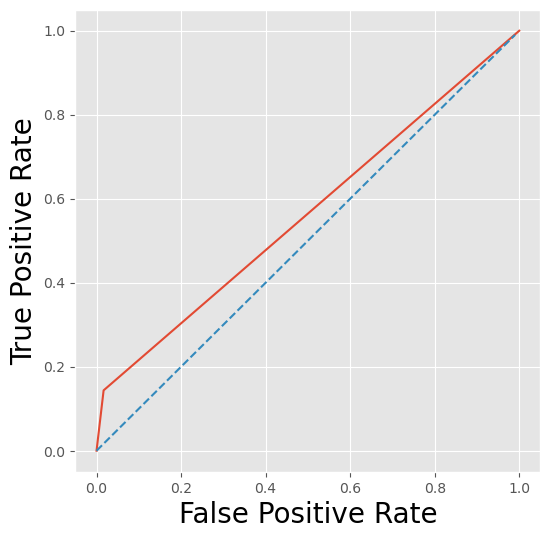

In [41]:
fpr, tpr, _ = roc_curve(y_test,  rf_preds)

#create ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

### AUC ROC i GINI

In [42]:
auc = roc_auc_score(y_test, rf_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.5635046230230837
GINI Score: 0.12700924604616737


## SVM

In [43]:
svc_model = SVC()

svc_model.fit(X_train_matrix, y_train)

SVC()

In [44]:
svc_preds = svc_model.predict(X_test_matrix)
svc_preds

array([0., 0., 0., ..., 0., 0., 1.])

In [45]:
print(classification_report(y_test, svc_preds))

              precision    recall  f1-score   support

         0.0       0.66      0.78      0.72      4838
         1.0       0.62      0.47      0.54      3673

    accuracy                           0.65      8511
   macro avg       0.64      0.63      0.63      8511
weighted avg       0.65      0.65      0.64      8511



### ROC Curve

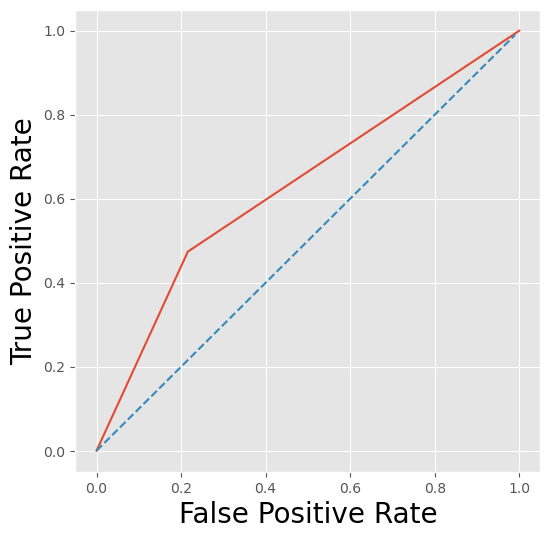

In [46]:
fpr, tpr, _ = roc_curve(y_test,  svc_preds)

#create ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

### AUC ROC i GINI

In [47]:
auc = roc_auc_score(y_test, svc_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.6290005545309183
GINI Score: 0.2580011090618366


# Naive Bayes

In [48]:
nb_model = GaussianNB()

nb_model.fit(X_train_matrix, y_train)

GaussianNB()

In [49]:
nb_preds = nb_model.predict(X_test_matrix)
nb_preds

array([0., 1., 1., ..., 1., 1., 1.])

In [50]:
print(classification_report(y_test, nb_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.53      0.59      4838
         1.0       0.51      0.63      0.56      3673

    accuracy                           0.57      8511
   macro avg       0.58      0.58      0.57      8511
weighted avg       0.59      0.57      0.58      8511



### ROC Curve

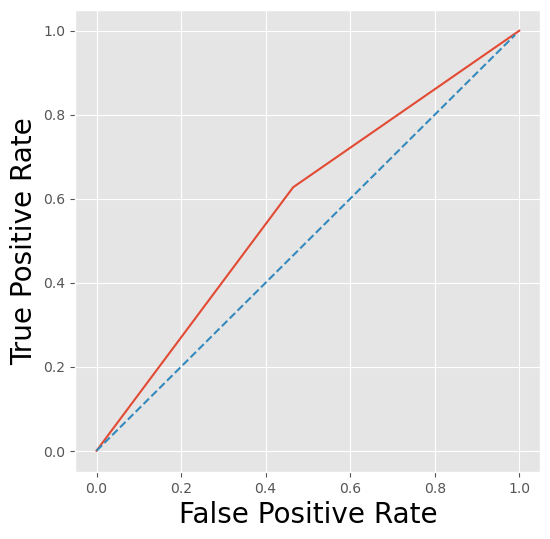

In [51]:
fpr, tpr, _ = roc_curve(y_test,  nb_preds)

#create ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

### AUC ROC i GINI

In [52]:
auc = roc_auc_score(y_test, nb_preds)
gini = 2 * auc - 1
print(f"AUC ROC Score: {auc}")
print(f"GINI Score: {gini}")

AUC ROC Score: 0.581105971229896
GINI Score: 0.1622119424597921


# Combined results

In [53]:
def get_stacking():
    level0 = list()
    level0.append(('xgb', xgb_model))
    level0.append(('lr', lr_model))
    level0.append(('rf', rf_model))
    level0.append(('svm', svc_model))
    level0.append(('bayes', nb_model))
    
    level1 = LogisticRegression()
    
    
    final_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return final_model

In [54]:
def get_models():
    
    models = dict()
    models['xgb'] = xgb.XGBClassifier(
                        max_depth = 8,
                        learning_rate = 0.03,
                        objectives = "binary:logistic",
                        verbosity=1)
    models['lr'] = LogisticRegression()
    models['rf'] = RandomForestClassifier(n_estimators=1000, # Ilość słabych estymatorów
                                      max_depth=2, # Maksymalna wysokość drzewa w słabym estymatorze
                                      min_samples_split = 2, # Minimalna ilość obserwacji wymagana do podziału węzła
                                      max_features = 3, # Maksymalna ilość zmiennych brana pod uwagę przy podziale węzła
                                      random_state=0,
                                      n_jobs = -1)
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()

    return models

In [55]:
def evaluate_model(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return scores

In [56]:
models = get_models()
# ocena modeli
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_test_matrix, y_test)
    results.append(scores)
    names.append(name)
    print('%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

     xgb mean-0.798 std-0.013
      lr mean-0.628 std-0.013
      rf mean-0.620 std-0.007
     svm mean-0.635 std-0.014
   bayes mean-0.573 std-0.022
stacking mean-0.802 std-0.012


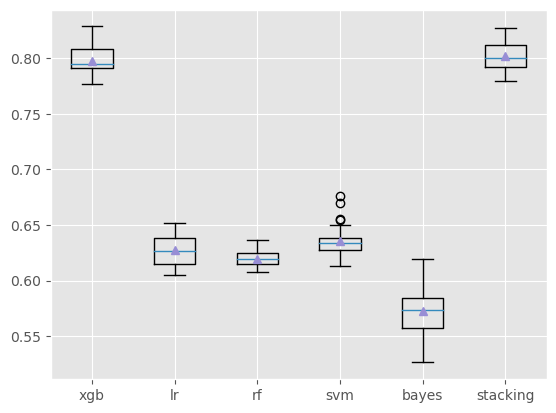

In [58]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()